***Set up environment***

Make sure you run this before running any of the sections!

In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [4]:
#Set up environment

# Basic
import pandas as pd
import numpy as np
import scipy.io
from os import mkdir, path, getcwd, chdir
from scipy.stats import norm
import pickle
import importlib
import io
from templateflow import api as tflow

%matplotlib inline

# Nipype
from nilearn import plotting
from nipype.interfaces.matlab import MatlabCommand
from nipype import Node, Workflow
MatlabCommand.set_default_paths('/opt/spm12-r7219/spm12_mcr/spm12')
from nipype.interfaces.base import Bunch
from nipype.interfaces.spm import EstimateModel
from nipype.interfaces.spm import EstimateContrast
from nipype.interfaces.spm import Normalize12
from nipype import SelectFiles
from nipype.algorithms.misc import Gunzip
from nipype.interfaces.io import DataSink
from nipype.algorithms.modelgen import SpecifySPMModel
from nipype.interfaces.spm import Level1Design
import nibabel as nb

# Nilearn
import nilearn
from nilearn.glm.first_level import FirstLevelModel
from nilearn.glm.second_level import SecondLevelModel
from nilearn.plotting import plot_stat_map, plot_anat, plot_img, show, plot_glass_brain
import matplotlib.pyplot as plt
from nilearn import input_data
from nilearn import image as nli
from nilearn.image import mean_img
from nilearn import input_data
from nilearn.glm.first_level import first_level_from_bids
from nilearn.glm.thresholding import threshold_stats_img
from nilearn.reporting import get_clusters_table
from nilearn.image import threshold_img
from nilearn.datasets import load_mni152_template
from nilearn.regions import connected_label_regions
from nilearn.datasets import fetch_atlas_harvard_oxford

#Utils - reload each time in case new function were added
import util
importlib.reload(util) 
import util
import eventfiles_wMot
importlib.reload(eventfiles_wMot) 
import eventfiles_wMot
import eventfiles
importlib.reload(eventfiles) 
import eventfiles

C:\Users\maxb.WISMAIN\Anaconda3\lib\site-packages\bids\layout\validation.py:46: UserWarning: The ability to pass arguments to BIDSLayout that control indexing is likely to be removed in future; possibly as early as PyBIDS 0.14. This includes the `config_filename`, `ignore`, `force_index`, and `index_metadata` arguments. The recommended usage pattern is to initialize a new BIDSLayoutIndexer with these arguments, and pass it to the BIDSLayout via the `indexer` argument.
  warnings.warn("The ability to pass arguments to BIDSLayout that control "


220605-12:22:20,463 nipype.utils WARNING:
	 A newer version (1.8.1) of nipy/nipype is available. You are using 1.7.0


C:\Users\maxb.WISMAIN\Anaconda3\lib\site-packages\nilearn\input_data\__init__.py:27: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


***Initialize paths and subjects***

In [5]:
#Paths
# behav_path = 'C:/Users/maxab/Dropbox (Weizmann Institute)/Max-and-Ella/task/stimuli_and_log/Log'
# mri_path = 'C:/Users/maxab/Dropbox (Weizmann Institute)/Max-and-Ella/MRI data'
# output_path = 'C:/Users/maxab/Dropbox (Weizmann Institute)/Max-and-Ella/MRI Analysis/Output'
# main_path = 'C:/Users/maxab/Dropbox (Weizmann Institute)/Max-and-Ella/MRI Analysis'

behav_path = 'C:/Users/maxb.WISMAIN/Dropbox (Weizmann Institute)/Max-and-Ella/task/stimuli_and_log/Log'
mri_path = 'C:/Users/maxb.WISMAIN/Dropbox (Weizmann Institute)/Max-and-Ella/MRI data'
output_path = 'C:/Users/maxb.WISMAIN/Dropbox (Weizmann Institute)/Max-and-Ella/MRI Analysis/Output'
main_path = 'C:/Users/maxb.WISMAIN/Dropbox (Weizmann Institute)/Max-and-Ella/MRI Analysis'

#Subjects
sub_list = np.arange(1201,1246)
sub_list = np.delete(sub_list,[1,8,21,25,26])

#Settings for processing
fName = 'DecisionStim'
grChoice = 'day' #day, night, both

#Define Subjects
day_list = np.arange(1201,1246)
day_list = np.delete(day_list,[1,8,21,25,26])
# day_list = np.delete(day_list,[0,1,8,21,25,26,3,4,5,12,14,16,22,24,27,29,30,32,33,37,38,44])
night_list = np.arange(1101,1145)
night_list = np.delete(night_list,[0,1,4,9,10,15,17,21,23,25,33,36,39,40,43])


In [6]:
#Choose sub list for each group or both groups
if grChoice == 'day':
    sub_list = day_list
elif grChoice == 'night':
    sub_list  = night_list
elif grChoice == 'both':
    sub_list = np.concatenate((day_list,night_list),axis=None)


#Switch to correct path
chdir(main_path)

#Check if path for particular GLM was created
if not path.exists("Output/{}".format(fName)):
    mode = 0o666
    curr_path = path.join(output_path, fName)
    mkdir(curr_path, mode)
else:
    curr_path = path.join(output_path, fName)

***Load zmaps and atlas***

In [7]:
atlas_cort = fetch_atlas_harvard_oxford('cortl-maxprob-thr25-2mm')
atlas_sub = fetch_atlas_harvard_oxford('sub-maxprob-thr25-2mm')

In [8]:
from nilearn.maskers import NiftiLabelsMasker

# Instantiate the masker with label image and label values
masker = NiftiLabelsMasker(atlas_cort.maps,
                           labels=atlas_cort.labels,
                           standardize=True)

# Visualize the atlas
# Note that we need to call fit prior to generating the mask
masker.fit()

# At this point, no functional image has been provided to the masker.
# We can still generate a report which can be displayed in a Jupyter
# Notebook, opened in a browser using the .open_in_browser() method,
# or saved to a file using the .save_as_html(output_filepath) method.
report = masker.generate_report()
report

C:\Users\maxb.WISMAIN\Anaconda3\lib\site-packages\nilearn\maskers\nifti_labels_masker.py:305: UserWarning: No image provided to fit in NiftiLabelsMasker. Plotting ROIs of label image on the MNI152Template for reporting.
  warnings.warn(msg)
C:\Users\maxb.WISMAIN\Anaconda3\lib\site-packages\nilearn\plotting\img_plotting.py:348: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  anat_img = load_mni152_template()


label value,region name,size (in mm^3),relative size (in %)
1,Left Frontal Pole,56528,5.42
2,Right Frontal Pole,66000,6.33
3,Left Insular Cortex,9280,0.89
4,Right Insular Cortex,9448,0.91
5,Left Superior Frontal Gyrus,20784,1.99
6,Right Superior Frontal Gyrus,19232,1.84
7,Left Middle Frontal Gyrus,22040,2.11
8,Right Middle Frontal Gyrus,20488,1.97
9,"Left Inferior Frontal Gyrus, pars triangularis",4856,0.47
10,"Right Inferior Frontal Gyrus, pars triangularis",3968,0.38


In [9]:
from nilearn.maskers import NiftiLabelsMasker

# Instantiate the masker with label image and label values
masker = NiftiLabelsMasker(atlas_sub.maps,
                           labels=atlas_sub.labels,
                           standardize=True)

# Visualize the atlas
# Note that we need to call fit prior to generating the mask
masker.fit()

# At this point, no functional image has been provided to the masker.
# We can still generate a report which can be displayed in a Jupyter
# Notebook, opened in a browser using the .open_in_browser() method,
# or saved to a file using the .save_as_html(output_filepath) method.
report = masker.generate_report()
report

C:\Users\maxb.WISMAIN\Anaconda3\lib\site-packages\nilearn\maskers\nifti_labels_masker.py:305: UserWarning: No image provided to fit in NiftiLabelsMasker. Plotting ROIs of label image on the MNI152Template for reporting.
  warnings.warn(msg)


label value,region name,size (in mm^3),relative size (in %)
1,Left Cerebral White Matter,250968,15.16
2,Left Cerebral Cortex,520560,31.45
3,Left Lateral Ventrical,9160,0.55
4,Left Thalamus,10568,0.64
5,Left Caudate,3896,0.24
6,Left Putamen,6392,0.39
7,Left Pallidum,2136,0.13
8,Brain-Stem,39120,2.36
9,Left Hippocampus,5528,0.33
10,Left Amygdala,2448,0.15


In [18]:
# Load thres map for all (Use sample contrastfor plotting)

contrast = 'negposReward'

try:
    thresALL_map
except NameError:
    thresALL_file = open("{}/{}_thresALL_dict_{}.pkl".format(curr_path,grChoice,fName), "rb")
    thresALL_map = pickle.load(thresALL_file)
    thresALL_file.close()

thisimg = thresALL_map['negposReward'][0]

***Get brain areas for loop***

(Put relevant brain areas in dictionary)

In [19]:
#Decide on areas
brainAreas = {}
brainAreas['Amygdala'] = {}
brainAreas['Amygdala']['Left'] = (nilearn.image.get_data(atlas_sub.maps) == 10) 
brainAreas['Amygdala']['Right'] = (nilearn.image.get_data(atlas_sub.maps) == 20) 
brainAreas['Caudate'] = {}
brainAreas['Caudate']['Left'] = (nilearn.image.get_data(atlas_sub.maps) == 5) #left
brainAreas['Caudate']['Right'] = (nilearn.image.get_data(atlas_sub.maps) == 16) #right
brainAreas['Putamen'] = {}
brainAreas['Putamen']['Left'] = (nilearn.image.get_data(atlas_sub.maps) == 6) #left
brainAreas['Putamen']['Right'] = (nilearn.image.get_data(atlas_sub.maps) == 17) #right
brainAreas['Pallidum'] = {}
brainAreas['Pallidum']['Left'] = (nilearn.image.get_data(atlas_sub.maps) == 7) #left
brainAreas['Pallidum']['Right'] = (nilearn.image.get_data(atlas_sub.maps) == 18) #right
brainAreas['Accumbens'] = {}
brainAreas['Accumbens']['Left'] = (nilearn.image.get_data(atlas_sub.maps) == 11) #left
brainAreas['Accumbens']['Right'] = (nilearn.image.get_data(atlas_sub.maps) == 21) #right
brainAreas['Thalamus'] = {}
brainAreas['Thalamus']['Left'] = (nilearn.image.get_data(atlas_sub.maps) == 4) #left
brainAreas['Thalamus']['Right'] = (nilearn.image.get_data(atlas_sub.maps) == 15) #right
brainAreas['Brainstem'] = {}
brainAreas['Brainstem']['Whole'] = (nilearn.image.get_data(atlas_sub.maps) == 8) #left
brainAreas['Insular'] = {}
brainAreas['Insular']['Left'] = (nilearn.image.get_data(atlas_cort.maps) == 3) #left
brainAreas['Insular']['Right'] = (nilearn.image.get_data(atlas_cort.maps) == 4) #right
brainAreas['Precuneous'] = {}
brainAreas['Precuneous']['Left'] = (nilearn.image.get_data(atlas_cort.maps) == 61) #left
brainAreas['Precuneous']['Right'] = (nilearn.image.get_data(atlas_cort.maps) == 62) #right
brainAreas['Cuneos'] = {}
brainAreas['Cuneos']['Left'] = (nilearn.image.get_data(atlas_cort.maps) == 63) #left
brainAreas['Cuneos']['Right'] = (nilearn.image.get_data(atlas_cort.maps) == 64) #right
brainAreas['Paracingulate gyrus'] = {}
brainAreas['Paracingulate gyrus']['Left'] = (nilearn.image.get_data(atlas_cort.maps) == 55) #left
brainAreas['Paracingulate gyrus']['Right'] = (nilearn.image.get_data(atlas_cort.maps) == 56) #right
brainAreas['Anterior cingulate gyrus'] = {}
brainAreas['Anterior cingulate gyrus']['Left'] = (nilearn.image.get_data(atlas_cort.maps) == 57) #left
brainAreas['Anterior cingulate gyrus']['Right'] = (nilearn.image.get_data(atlas_cort.maps) == 58) #right
brainAreas['Posterior cingulate gyrus'] = {}
brainAreas['Posterior cingulate gyrus']['Left'] = (nilearn.image.get_data(atlas_cort.maps) == 59) #left
brainAreas['Posterior cingulate gyrus']['Right'] = (nilearn.image.get_data(atlas_cort.maps) == 60) #right
brainAreas['Frontoorbital cortex'] = {}
brainAreas['Frontoorbital cortex']['Left'] = (nilearn.image.get_data(atlas_cort.maps) == 65) #left
brainAreas['Frontoorbital cortex']['Right'] = (nilearn.image.get_data(atlas_cort.maps) == 66) #right
brainAreas['Frontomedial cortex'] = {}
brainAreas['Frontomedial cortex']['Left'] = (nilearn.image.get_data(atlas_cort.maps) == 49) #left
brainAreas['Frontomedial cortex']['Right'] = (nilearn.image.get_data(atlas_cort.maps) == 50) #right
brainAreas['Subcallosal cortex'] = {}
brainAreas['Subcallosal cortex']['Left'] = (nilearn.image.get_data(atlas_cort.maps) == 53) #left
brainAreas['Subcallosal cortex']['Right'] = (nilearn.image.get_data(atlas_cort.maps) == 54) #right
brainAreas['Ant sup temp gyrus'] = {}
brainAreas['Ant sup temp gyrus']['Left'] = (nilearn.image.get_data(atlas_cort.maps) == 17) #left
brainAreas['Ant sup temp gyrus']['Right'] = (nilearn.image.get_data(atlas_cort.maps) == 18) #right
brainAreas['Pos sup temp gyrus'] = {}
brainAreas['Pos sup temp gyrus']['Left'] = (nilearn.image.get_data(atlas_cort.maps) == 19) #left
brainAreas['Pos sup temp gyrus']['Right'] = (nilearn.image.get_data(atlas_cort.maps) == 20) #right
brainAreas['Ant mid temp gyrus'] = {}
brainAreas['Ant mid temp gyrus']['Left'] = (nilearn.image.get_data(atlas_cort.maps) == 21) #left
brainAreas['Ant mid temp gyrus']['Right'] = (nilearn.image.get_data(atlas_cort.maps) == 22) #right
brainAreas['Pos mid temp gyrus'] = {}
brainAreas['Pos mid temp gyrus']['Left'] = (nilearn.image.get_data(atlas_cort.maps) == 23) #left
brainAreas['Pos mid temp gyrus']['Right'] = (nilearn.image.get_data(atlas_cort.maps) == 24) #right
brainAreas['Temp mid temp gyrus'] = {}
brainAreas['Temp mid temp gyrus']['Left'] = (nilearn.image.get_data(atlas_cort.maps) == 25) #left
brainAreas['Temp mid temp gyrus']['Right'] = (nilearn.image.get_data(atlas_cort.maps) == 26) #right
brainAreas['Postcentral gyrus'] = {}
brainAreas['Postcentral gyrus']['Left'] = (nilearn.image.get_data(atlas_cort.maps) == 33) #left
brainAreas['Postcentral gyrus']['Right'] = (nilearn.image.get_data(atlas_cort.maps) == 34) #right
brainAreas['Temp FC Ant'] = {}
brainAreas['Temp FC Ant']['Left'] = (nilearn.image.get_data(atlas_cort.maps) == 73) #left
brainAreas['Temp FC Ant']['Right'] = (nilearn.image.get_data(atlas_cort.maps) == 74) #right
brainAreas['Temp FC Post'] = {}
brainAreas['Temp FC Post']['Left'] = (nilearn.image.get_data(atlas_cort.maps) == 75) #left
brainAreas['Temp FC Post']['Right'] = (nilearn.image.get_data(atlas_cort.maps) == 76) #right
brainAreas['TempOcc FC'] = {}
brainAreas['TempOcc FC']['Left'] = (nilearn.image.get_data(atlas_cort.maps) == 77) #left
brainAreas['TempOcc FC']['Right'] = (nilearn.image.get_data(atlas_cort.maps) == 78) #right
brainAreas['Occ FG'] = {}
brainAreas['Occ FG']['Left'] = (nilearn.image.get_data(atlas_cort.maps) == 79) #left
brainAreas['Occ FG']['Right'] = (nilearn.image.get_data(atlas_cort.maps) == 80) #right


  Plot outline of Amygdala 
  Plot outline of Caudate 
  Plot outline of Putamen 
  Plot outline of Pallidum 
  Plot outline of Accumbens 
  Plot outline of Thalamus 
  Plot outline of Brainstem 
  Plot outline of Insular 
  Plot outline of Precuneous 
  Plot outline of Cuneos 
  Plot outline of Paracingulate gyrus 
  Plot outline of Anterior cingulate gyrus 
  Plot outline of Posterior cingulate gyrus 
  Plot outline of Frontoorbital cortex 
  Plot outline of Frontomedial cortex 
  Plot outline of Subcallosal cortex 
  Plot outline of Ant sup temp gyrus 
  Plot outline of Pos sup temp gyrus 
  Plot outline of Ant mid temp gyrus 
  Plot outline of Pos mid temp gyrus 
  Plot outline of Temp mid temp gyrus 


C:\Users\maxb.WISMAIN\Anaconda3\lib\site-packages\nilearn\plotting\displays\_slicers.py:145: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure = plt.figure(figure, figsize=figsize,


  Plot outline of Postcentral gyrus 
  Plot outline of Temp FC Ant 
  Plot outline of Temp FC Post 
  Plot outline of TempOcc FC 
  Plot outline of Occ FG 
 Plot outlines for contrast negposReward 


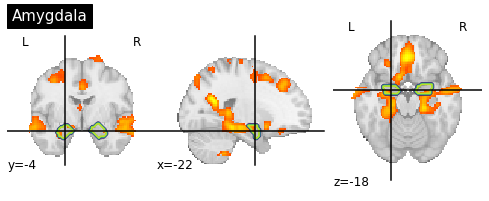

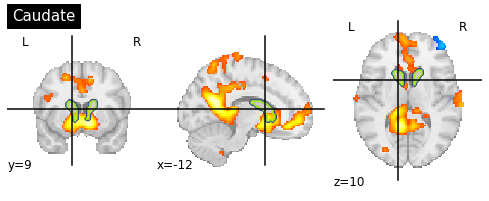

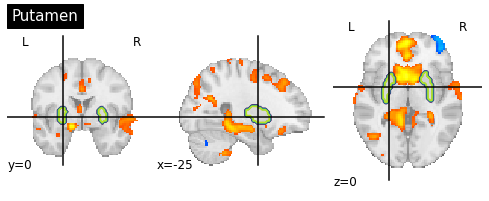

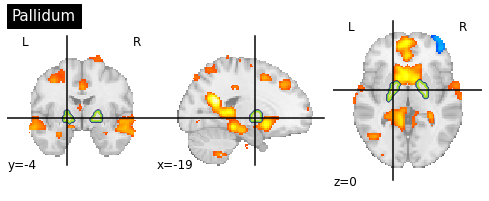

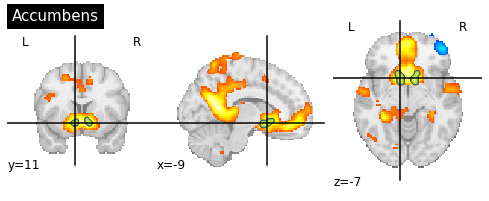

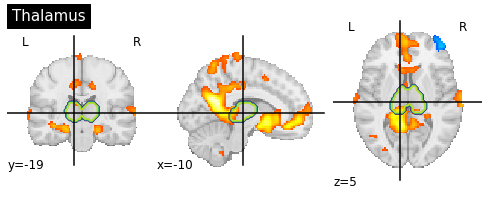

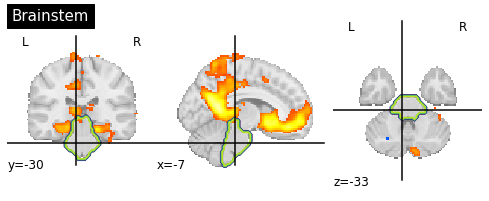

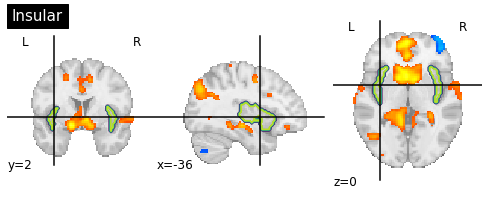

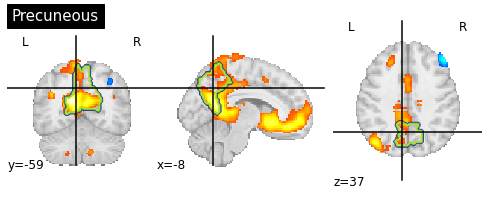

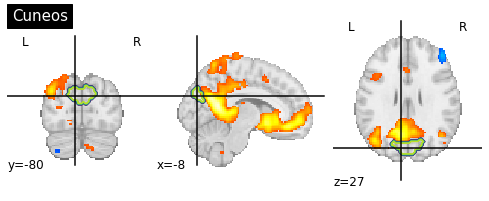

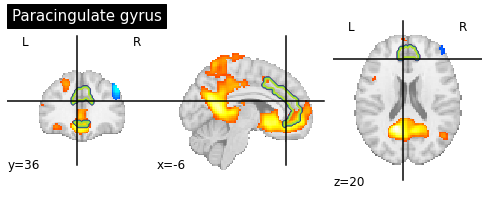

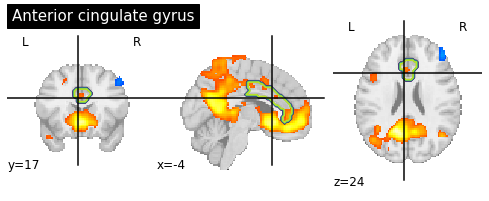

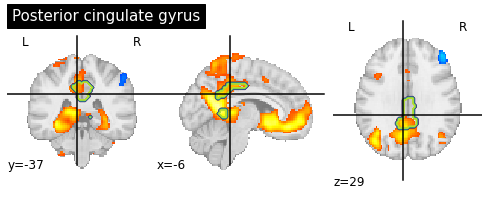

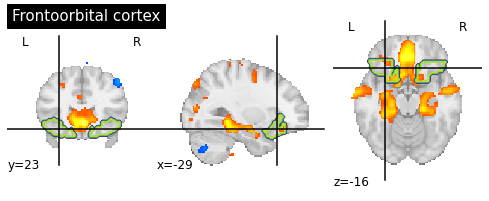

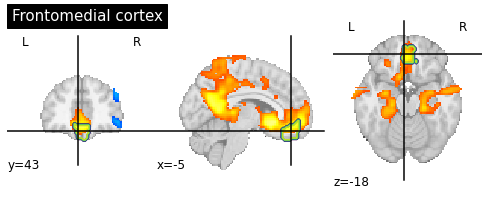

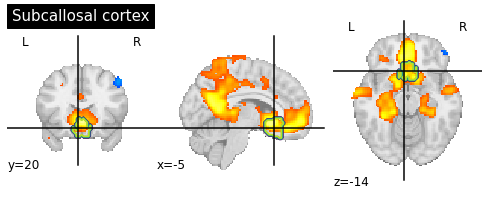

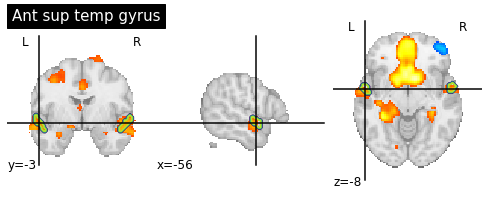

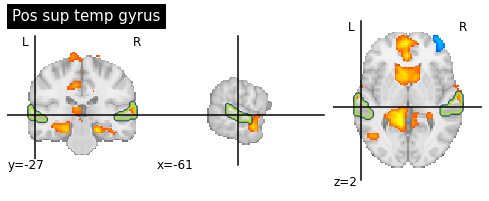

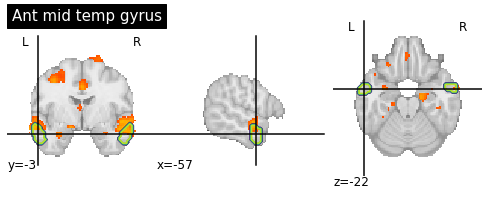

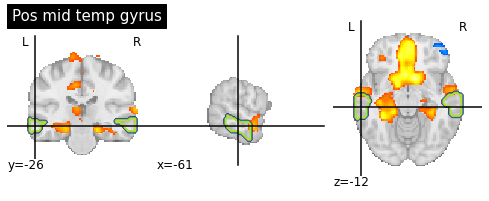

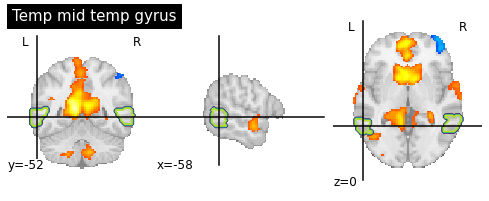

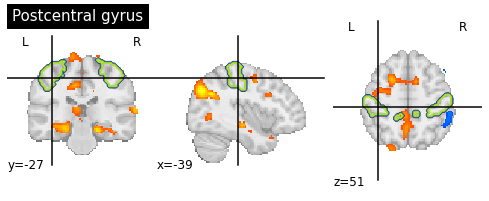

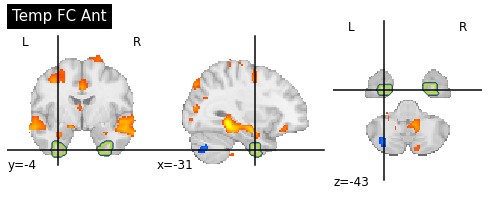

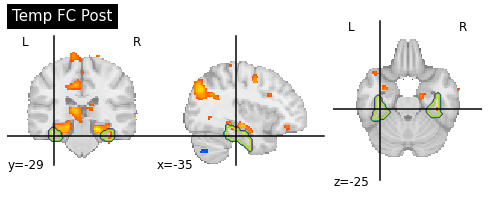

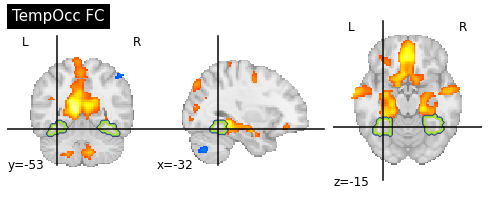

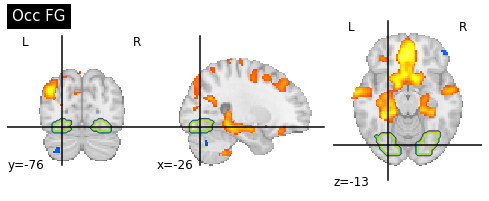

In [20]:
all_coords = []

for index, (area,subarea) in enumerate(brainAreas.items()):

    print('  Plot outline of %s ' % (area))

    #Get area and zmap
    if list(subarea.keys())[0] == 'Left':
        area_logic = np.logical_or(brainAreas[area]['Left'], brainAreas[area]['Right'])
    elif list(subarea.keys())[0] == 'Whole':
        area_logic = brainAreas[area]['Whole']
    
    img_from_atlas = nilearn.image.new_img_like(atlas_sub.maps,area_logic)
    resampled_atlas_red = nilearn.image.resample_to_img(img_from_atlas, thisimg, interpolation = 'nearest')

    #Get locus of mask
    curr_cut_coords = nilearn.plotting.find_parcellation_cut_coords(resampled_atlas_red)
    all_coords.append(curr_cut_coords)


    display = nilearn.plotting.plot_stat_map(thisimg, 
                                             colorbar=False, 
                                             cut_coords = tuple(map(tuple,curr_cut_coords))[0],
                                             title=area)
    display.add_contours(resampled_atlas_red)

print(' Plot outlines for contrast %s ' % (contrast))

***Plot all areas together from different angles***

In [21]:
#Decide on areas
allAreas =((nilearn.image.get_data(atlas_sub.maps) == 10), #Amygdala
           (nilearn.image.get_data(atlas_sub.maps) == 20), 
           (nilearn.image.get_data(atlas_sub.maps) == 5), #Caudate
           (nilearn.image.get_data(atlas_sub.maps) == 16),
           (nilearn.image.get_data(atlas_sub.maps) == 6), #Putamen
           (nilearn.image.get_data(atlas_sub.maps) == 17),
           (nilearn.image.get_data(atlas_sub.maps) == 7), #Pallidum
           (nilearn.image.get_data(atlas_sub.maps) == 18),
           (nilearn.image.get_data(atlas_sub.maps) == 11), #Accumbens
           (nilearn.image.get_data(atlas_sub.maps) == 21),
           (nilearn.image.get_data(atlas_sub.maps) == 4), #Thalamus
           (nilearn.image.get_data(atlas_sub.maps) == 15),
           (nilearn.image.get_data(atlas_sub.maps) == 8), #Brainstem
           (nilearn.image.get_data(atlas_cort.maps) == 3), #Insular
           (nilearn.image.get_data(atlas_cort.maps) == 4),
           (nilearn.image.get_data(atlas_cort.maps) == 61), #Precuneous
           (nilearn.image.get_data(atlas_cort.maps) == 62),
           (nilearn.image.get_data(atlas_cort.maps) == 63), #Cuneos
           (nilearn.image.get_data(atlas_cort.maps) == 64),
           (nilearn.image.get_data(atlas_cort.maps) == 57), #ACC
           (nilearn.image.get_data(atlas_cort.maps) == 58),
           (nilearn.image.get_data(atlas_cort.maps) == 65), #Frontoorbital
           (nilearn.image.get_data(atlas_cort.maps) == 66),
           (nilearn.image.get_data(atlas_cort.maps) == 49), #Frontomedial
           (nilearn.image.get_data(atlas_cort.maps) == 50),
           (nilearn.image.get_data(atlas_cort.maps) == 53), #Subcallosal
           (nilearn.image.get_data(atlas_cort.maps) == 54),
           (nilearn.image.get_data(atlas_cort.maps) == 17), #Sup temp anterior
           (nilearn.image.get_data(atlas_cort.maps) == 18), 
           (nilearn.image.get_data(atlas_cort.maps) == 19), #Sup temp posterior
           (nilearn.image.get_data(atlas_cort.maps) == 20), 
           (nilearn.image.get_data(atlas_cort.maps) == 21), #Medial temp anterior
           (nilearn.image.get_data(atlas_cort.maps) == 22), 
           (nilearn.image.get_data(atlas_cort.maps) == 23), #Medial temp anterior
           (nilearn.image.get_data(atlas_cort.maps) == 24), 
           (nilearn.image.get_data(atlas_cort.maps) == 25), #Tempomedial gyrus
           (nilearn.image.get_data(atlas_cort.maps) == 26), 
           (nilearn.image.get_data(atlas_cort.maps) == 33), #Postcentral gyrus
           (nilearn.image.get_data(atlas_cort.maps) == 34), 
           (nilearn.image.get_data(atlas_cort.maps) == 73), #Temp FC Ant
           (nilearn.image.get_data(atlas_cort.maps) == 74), 
           (nilearn.image.get_data(atlas_cort.maps) == 75), #Temp FC Post
           (nilearn.image.get_data(atlas_cort.maps) == 76), 
           (nilearn.image.get_data(atlas_cort.maps) == 77), #TempOcc FC
           (nilearn.image.get_data(atlas_cort.maps) == 78), 
           (nilearn.image.get_data(atlas_cort.maps) == 79), #Occ FG
           (nilearn.image.get_data(atlas_cort.maps) == 80) 
          )


In [22]:
#Make reduced atlas
area_logic = np.logical_or.reduce(allAreas)
img_from_atlas = nilearn.image.new_img_like(atlas_sub.maps,area_logic)
resampled_atlas_red = nilearn.image.resample_to_img(img_from_atlas, thisimg, interpolation = 'nearest')


***Plot all ROIs***

  Plot all outlines on Amygdala -centered slice 
  Plot all outlines on Caudate -centered slice 
  Plot all outlines on Putamen -centered slice 
  Plot all outlines on Pallidum -centered slice 
  Plot all outlines on Accumbens -centered slice 
  Plot all outlines on Thalamus -centered slice 
  Plot all outlines on Brainstem -centered slice 
  Plot all outlines on Insular -centered slice 
  Plot all outlines on Precuneous -centered slice 
  Plot all outlines on Cuneos -centered slice 
  Plot all outlines on Paracingulate gyrus -centered slice 
  Plot all outlines on Anterior cingulate gyrus -centered slice 
  Plot all outlines on Posterior cingulate gyrus -centered slice 
  Plot all outlines on Frontoorbital cortex -centered slice 
  Plot all outlines on Frontomedial cortex -centered slice 
  Plot all outlines on Subcallosal cortex -centered slice 
  Plot all outlines on Ant sup temp gyrus -centered slice 
  Plot all outlines on Pos sup temp gyrus -centered slice 
  Plot all outlines on

C:\Users\maxb.WISMAIN\Anaconda3\lib\site-packages\nilearn\plotting\displays\_slicers.py:145: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure = plt.figure(figure, figsize=figsize,


  Plot all outlines on Postcentral gyrus -centered slice 
  Plot all outlines on Temp FC Ant -centered slice 
  Plot all outlines on Temp FC Post -centered slice 
  Plot all outlines on TempOcc FC -centered slice 
  Plot all outlines on Occ FG -centered slice 


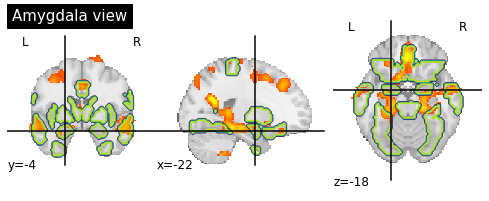

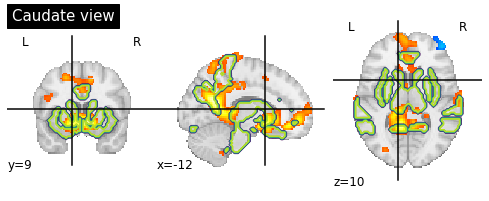

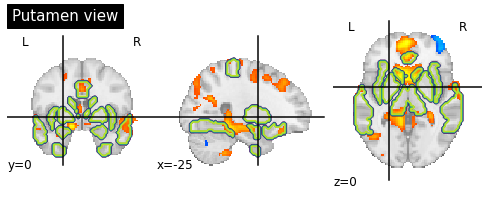

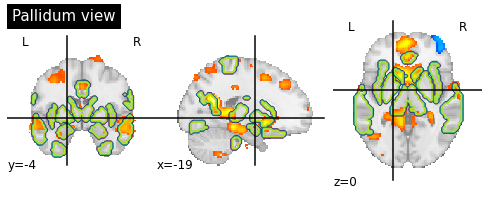

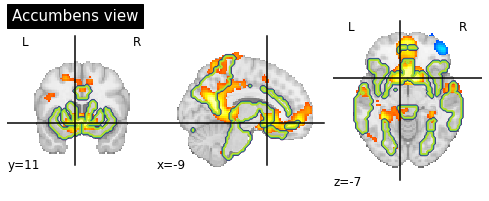

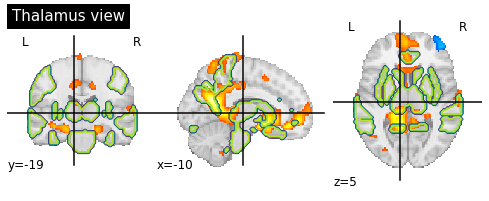

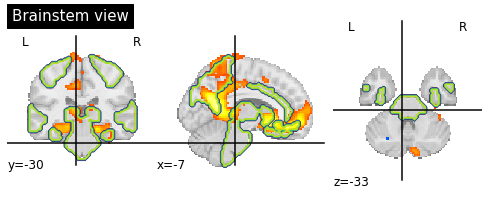

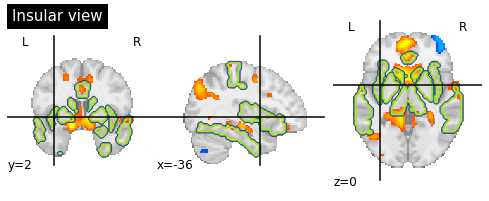

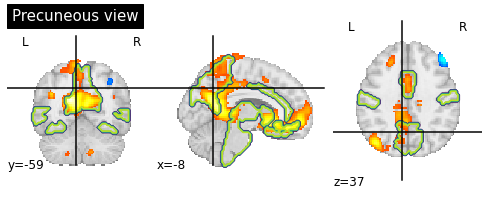

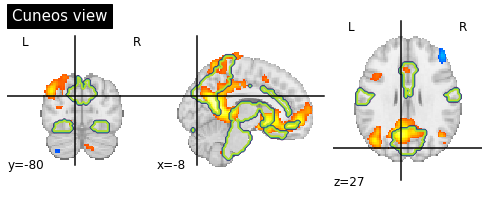

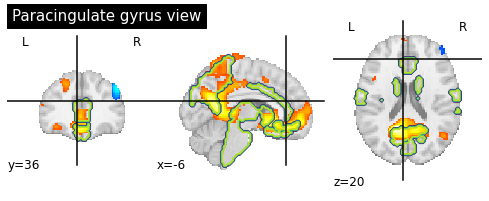

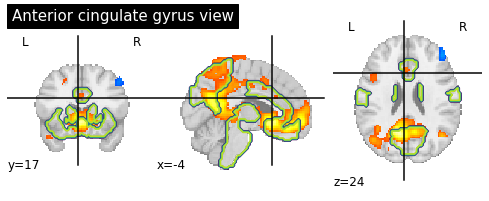

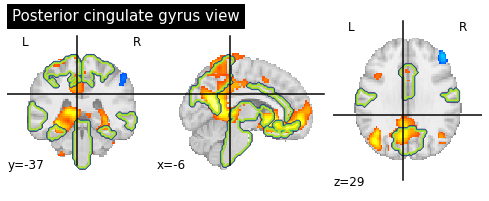

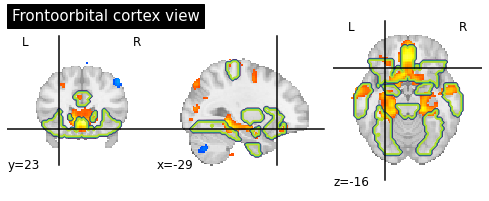

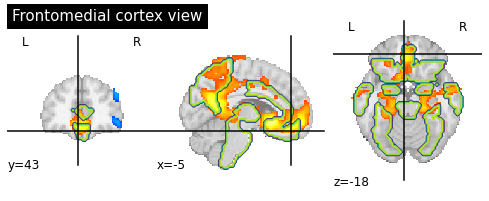

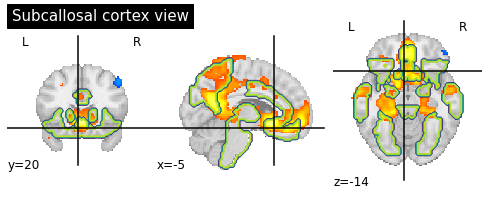

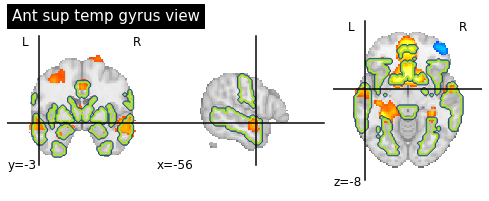

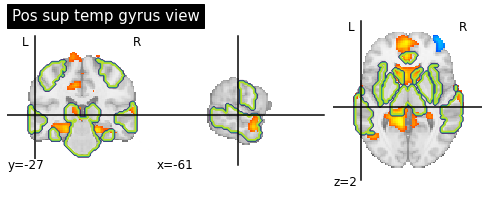

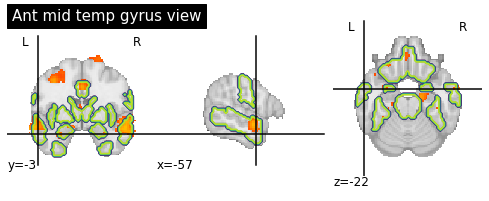

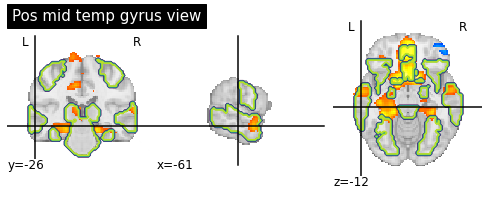

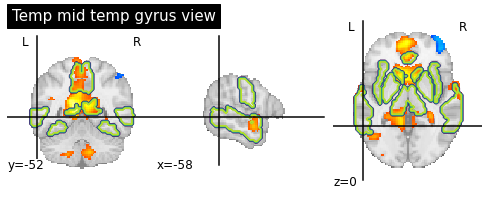

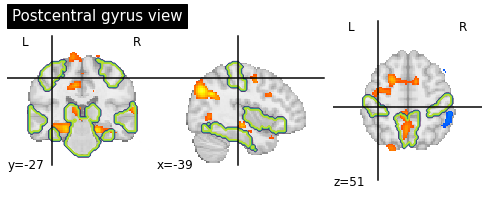

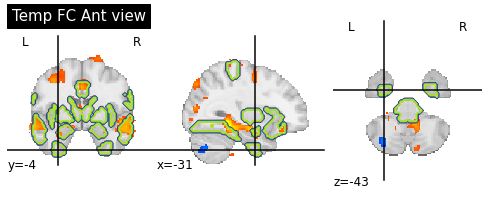

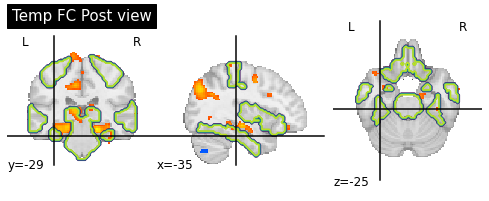

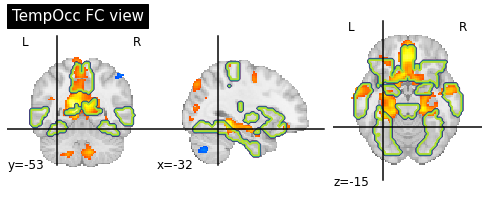

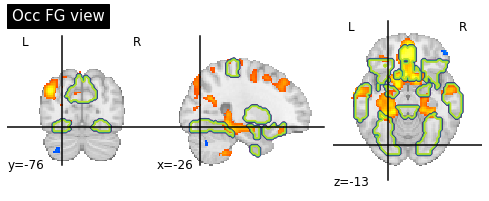

In [23]:
#Plot on brain

for index, (area,subarea) in enumerate(brainAreas.items()):
    
    print('  Plot all outlines on %s -centered slice ' % (area))

    display = nilearn.plotting.plot_stat_map(thisimg, colorbar=False, 
                                             cut_coords = tuple(map(tuple,all_coords[index]))[0],
                                             title=area + ' view')
    display.add_contours(resampled_atlas_red)



***Save dict of areas for this GLM***

(All ROIs for all contrasts)

In [24]:
#Decide on areas
brainAreas = {}
brainAreas['Amygdala'] = {}
brainAreas['Amygdala']['Left'] = (nilearn.image.get_data(atlas_sub.maps) == 10) 
brainAreas['Amygdala']['Right'] = (nilearn.image.get_data(atlas_sub.maps) == 20) 
brainAreas['Accumbens'] = {}
brainAreas['Accumbens']['Left'] = (nilearn.image.get_data(atlas_sub.maps) == 11) #left
brainAreas['Accumbens']['Right'] = (nilearn.image.get_data(atlas_sub.maps) == 21) #right
brainAreas['Precuneous'] = {}
brainAreas['Precuneous']['Left'] = (nilearn.image.get_data(atlas_cort.maps) == 61) #left
brainAreas['Precuneous']['Right'] = (nilearn.image.get_data(atlas_cort.maps) == 62) #right
brainAreas['Frontomedial cortex'] = {}
brainAreas['Frontomedial cortex']['Left'] = (nilearn.image.get_data(atlas_cort.maps) == 49) #left
brainAreas['Frontomedial cortex']['Right'] = (nilearn.image.get_data(atlas_cort.maps) == 50) #right
brainAreas['Subcallosal cortex'] = {}
brainAreas['Subcallosal cortex']['Left'] = (nilearn.image.get_data(atlas_cort.maps) == 53) #left
brainAreas['Subcallosal cortex']['Right'] = (nilearn.image.get_data(atlas_cort.maps) == 54) #right
brainAreas['Paracingulate gyrus'] = {}
brainAreas['Paracingulate gyrus']['Left'] = (nilearn.image.get_data(atlas_cort.maps) == 55) #left
brainAreas['Paracingulate gyrus']['Right'] = (nilearn.image.get_data(atlas_cort.maps) == 56) #right
brainAreas['Posterior cingulate gyrus'] = {}
brainAreas['Posterior cingulate gyrus']['Left'] = (nilearn.image.get_data(atlas_cort.maps) == 59) #left
brainAreas['Posterior cingulate gyrus']['Right'] = (nilearn.image.get_data(atlas_cort.maps) == 60) #right
brainAreas['Ant sup temp gyrus'] = {}
brainAreas['Ant sup temp gyrus']['Left'] = (nilearn.image.get_data(atlas_cort.maps) == 17) #left
brainAreas['Ant sup temp gyrus']['Right'] = (nilearn.image.get_data(atlas_cort.maps) == 18) #right

#Save
ROIALL_file = open("{}/{}_allROIs_{}.pkl".format(curr_path,grChoice,fName), "wb")
pickle.dump(brainAreas, ROIALL_file)
ROIALL_file.close() 